In [1]:
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import decomposition, discriminant_analysis, ensemble, \
    linear_model, metrics, model_selection, naive_bayes, svm, utils
from nltk import tokenize
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm

from pan20 import auth, util
from pan20.util import text, topkfreqs
from pan20.util.lexicons import noble

### Get small enough set to work comfortably in memory

In [2]:
# saves to tmp under the hood - can call without fear of losing 30mins
train_ixs, dev_ixs, test_ixs, y_train, y_dev, y_test = auth.ten_k_set()

In [5]:
ks = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

### Calculate Freqs

In [3]:
# saves and loads under the hood
for n in [1, 2, 3]:
    _ = topkfreqs.small_freqs(n)

### Get Top-K

In [6]:
# generate if not already done
for n in [1, 2, 3]:
    with tqdm(total=len(ks)) as pbar:
        for k in ks:
            _ = topkfreqs.get_top_k(k, n=n)
            pbar.update()

### Calculate Entropies

In [40]:
with tqdm(total=3, desc='n') as npbar:
    for n in [1, 2, 3]:
        npbar.set_description(f'n = {n}')
        with tqdm(total=len(ks), desc='k') as kpbar:
            for k in ks:
                kpbar.set_description(f'k = {k}')
                _ = topkfreqs.top_k_doc_ent(k, n=n)
                kpbar.update()
        npbar.update()

MemoryError: Unable to allocate 3.21 GiB for an array with shape (430907392,) and data type float64

### Basic Classifiers

In [4]:
def evaluate(k, n):
    X_train, y_train, X_dev, y_dev, X_test, y_test = topkfreqs.top_k_Xy(k, n)
    
    results = []
    def get_results(clf, name):
        results.append({
            'model': name,
            'k': k,
            'train': metrics.accuracy_score(y_train, clf.predict(X_train)),
            'dev': metrics.accuracy_score(y_dev, clf.predict(X_dev)),
            'test': metrics.accuracy_score(y_test, clf.predict(X_test)),
        })
    
    nb = naive_bayes.GaussianNB()
    nb.fit(X_train, y_train)
    get_results(nb, 'naive_bayes')
    
    svc = svm.SVC(C=1., kernel='rbf')
    svc.fit(X_train, y_train)
    get_results(svc, 'svc')
    
    rf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=15)
    rf.fit(X_train, y_train)
    get_results(rf, 'random_forest')
    
    lda = discriminant_analysis.LinearDiscriminantAnalysis(solver='eigen')
    lda.fit(X_train, y_train)
    get_results(lda, 'linear_discriminant_analysis')
    
    return results

In [ ]:
evaluate(2056, n=3)

In [6]:
results3 = []
with tqdm(total=len(ks)) as pbar:
    for k in ks:
        if k > 1024:
            continue
        pbar.set_description(f'k = {k}')
        results3 += evaluate(k, n=3)
        pbar.update()
results3 = pd.DataFrame(results3)

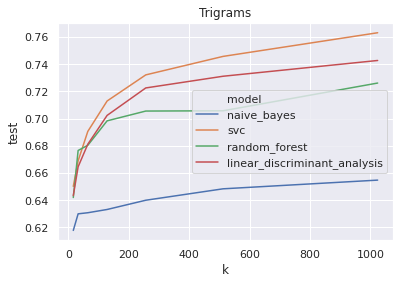

In [7]:
sns.lineplot(data=results3, x='k', y='test', hue='model')
plt.title('Trigrams')
plt.show()

In [8]:
results3.sort_values(by=['dev'], ascending=False).head(10)

,model,k,train,dev,test
25,svc,1024,0.8067,0.7588,0.7632
21,svc,512,0.8023,0.7542,0.7458
27,linear_discriminant_analysis,1024,0.8040,0.7468,0.7428
23,linear_discriminant_analysis,512,0.7623,0.7360,0.7312
17,svc,256,0.7789,0.7204,0.7322
19,linear_discriminant_analysis,256,0.7325,0.7120,0.7226
26,random_forest,1024,0.9996,0.7100,0.7262
22,random_forest,512,0.9994,0.7064,0.7058
13,svc,128,0.7699,0.7050,0.7130
15,linear_discriminant_analysis,128,0.7042,0.6982,0.7024


In [8]:
results2 = []
with tqdm(total=len(ks)) as pbar:
    for k in ks:
        pbar.set_description(f'k = {k}')
        results2 += evaluate(k, n=2)
        pbar.update()
results2 = pd.DataFrame(results2)

Results for bigrams:

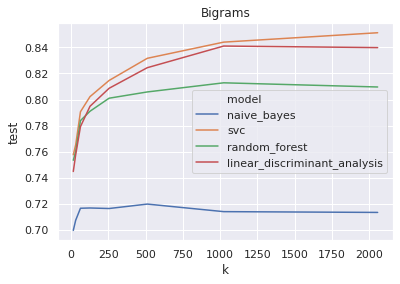

In [16]:
sns.lineplot(data=results2, x='k', y='test', hue='model')
plt.title('Bigrams')
plt.show()

In [11]:
results2.sort_values(by=['dev'], ascending=False).head(10)

,model,k,train,dev,test
29,svc,2056,0.9073,0.8552,0.8512
25,svc,1024,0.8980,0.8484,0.8440
27,linear_discriminant_analysis,1024,0.8802,0.8446,0.8410
21,svc,512,0.8843,0.8386,0.8316
31,linear_discriminant_analysis,2056,0.9137,0.8340,0.8398
23,linear_discriminant_analysis,512,0.8532,0.8294,0.8244
17,svc,256,0.8661,0.8288,0.8146
26,random_forest,1024,1.0000,0.8204,0.8128
19,linear_discriminant_analysis,256,0.8261,0.8196,0.8086
30,random_forest,2056,1.0000,0.8136,0.8096


Results for unigrams:

In [12]:
results1 = []
with tqdm(total=len(ks)) as pbar:
    for k in ks:
        pbar.set_description(f'k = {k}')
        results1 += evaluate(k, n=1)
        pbar.update()
results1 = pd.DataFrame(results1)

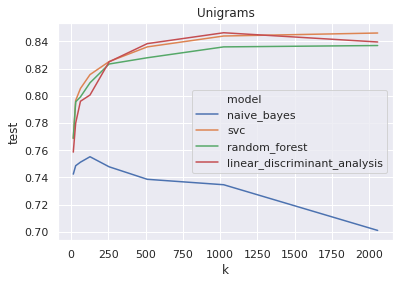

In [15]:
sns.lineplot(data=results1, x='k', y='test', hue='model')
plt.title('Unigrams')
plt.show()

In [14]:
results1.sort_values(by=['dev'], ascending=False).head(10)

,model,k,train,dev,test
29,svc,2056,0.8934,0.8462,0.8462
25,svc,1024,0.8784,0.8446,0.8440
26,random_forest,1024,1.0000,0.8380,0.8360
27,linear_discriminant_analysis,1024,0.8863,0.8378,0.8464
21,svc,512,0.8682,0.8374,0.8360
30,random_forest,2056,1.0000,0.8370,0.8370
31,linear_discriminant_analysis,2056,0.9218,0.8364,0.8396
22,random_forest,512,0.9999,0.8346,0.8280
23,linear_discriminant_analysis,512,0.8621,0.8330,0.8384
17,svc,256,0.8566,0.8320,0.8252


### PCA

In [250]:
# see what PCA gives us
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

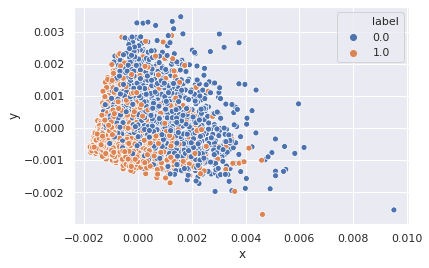

In [251]:
# this is representative of all three sets
pca_test = pca.transform(X_test)
pca_test = np.concatenate([pca_test, np.expand_dims(y_test, 1)], axis=1)
pca_test = pd.DataFrame(pca_test, columns=['x', 'y', 'label'])
sns.scatterplot(data=pca_test, x='x', y='y', hue='label')
plt.show()

## Noble Dict

In [39]:
nd = noble.NobleDict()

In [35]:
cf('I am a silly person going to sleep.')

{'adverbs': 0.0,
 'articles': 0.1111111111111111,
 'auxiliary_verbs': 0.1111111111111111,
 'conjunctions': 0.0,
 'impersonal_pronouns': 0.0,
 'personal_pronouns': 0.0,
 'prepositions': 0.1111111111111111,
 'quantifiers': 0.0,
 'n': 9,
 'function_words': 0.3333333333333333}

In [36]:
X, y = auth.load_small()

In [37]:
cat_dict = util.IxDict(noble.cats)

In [41]:
X_train = []
X_dev = []
X_test = []

def get_vec(toks):
    vec = np.zeros((1, len(cat_dict)))
    for tok in toks:
        for cat in nd.cats_for(tok):
            cat_ix = cat_dict[cat]
            vec[0, cat_ix] += 1
    vec  = vec / len(toks)
    return vec

for ix in train_ixs:
    t0 = X[ix]['pair'][0]
    t1 = X[ix]['pair'][1]
    t0 = text.tokenize(t0)
    t1 = text.tokenize(t1)
    v0 = get_vec(t0)
    v1 = get_vec(t1)
    diff = np.abs(v0 - v1)
    X_train.append(diff)

for ix in dev_ixs:
    t0 = X[ix]['pair'][0]
    t1 = X[ix]['pair'][1]
    t0 = text.tokenize(t0)
    t1 = text.tokenize(t1)
    v0 = get_vec(t0)
    v1 = get_vec(t1)
    diff = np.abs(v0 - v1)
    X_dev.append(diff)

for ix in test_ixs:
    t0 = X[ix]['pair'][0]
    t1 = X[ix]['pair'][1]
    t0 = text.tokenize(t0)
    t1 = text.tokenize(t1)
    v0 = get_vec(t0)
    v1 = get_vec(t1)
    diff = np.abs(v0 - v1)
    X_test.append(diff)

X_train = np.concatenate(X_train, axis=0)
X_dev = np.concatenate(X_dev, axis=0)
X_test = np.concatenate(X_test, axis=0)

In [43]:
svc = svm.SVC(C=1., kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
metrics.accuracy_score(y_train, svc.predict(X_train))

0.7055

In [45]:
metrics.accuracy_score(y_dev, svc.predict(X_dev))

0.704

In [46]:
metrics.accuracy_score(y_test, svc.predict(X_test))

0.7078

Little PCA, too.

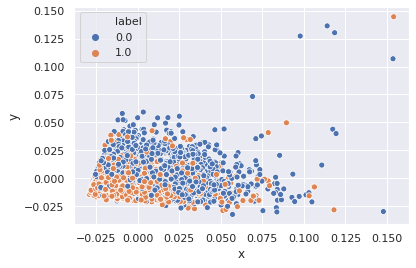

In [47]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
pca_test = pca.transform(X_test)
pca_test = np.concatenate([pca_test, np.expand_dims(y_test, 1)], axis=1)
pca_test = pd.DataFrame(pca_test, columns=['x', 'y', 'label'])
sns.scatterplot(data=pca_test, x='x', y='y', hue='label')
plt.show()

## Best Features

In [48]:
X_train_noble = X_train
X_dev_noble = X_dev
X_test_noble = X_test

In [49]:
X_train_1, y_train_1, X_dev_1, y_dev_1, X_test_1, y_test_1 = topkfreqs.top_k_Xy(1024, 1)
X_train_2, _, X_dev_2, _, X_test_2, _ = topkfreqs.top_k_Xy(2056, 2)

In [50]:
X_train = np.concatenate([X_train_1, X_train_2, X_train_noble], axis=1)
X_dev = np.concatenate([X_dev_1, X_dev_2, X_dev_noble], axis=1)
X_test = np.concatenate([X_test_1, X_test_2, X_test_noble], axis=1)

In [51]:
results = []

def get_results(clf, name):
    results.append({
        'model': name,
        'k': k,
        'train': metrics.accuracy_score(y_train, clf.predict(X_train)),
        'dev': metrics.accuracy_score(y_dev, clf.predict(X_dev)),
        'test': metrics.accuracy_score(y_test, clf.predict(X_test)),
    })

nb = naive_bayes.GaussianNB()
nb.fit(X_train, y_train)
get_results(nb, 'naive_bayes')

svc = svm.SVC(C=1., kernel='rbf')
svc.fit(X_train, y_train)
get_results(svc, 'svc')

rf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=15)
rf.fit(X_train, y_train)
get_results(rf, 'random_forest')

lda = discriminant_analysis.LinearDiscriminantAnalysis(solver='eigen')
lda.fit(X_train, y_train)
get_results(lda, 'linear_discriminant_analysis')

results = pd.DataFrame(results)

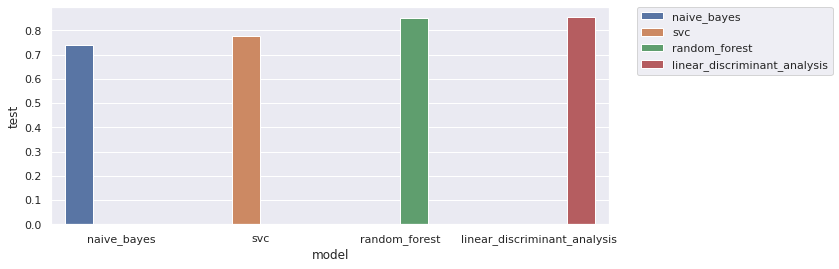

In [52]:
plt.figure(figsize=(10, 4))
sns.barplot(data=results.sort_values(by=['test']).reset_index(), x='model', y='test', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [53]:
results.sort_values(by=['test'], ascending=False).head(10)

,model,k,train,dev,test
3,linear_discriminant_analysis,2056,0.9555,0.8444,0.8534
2,random_forest,2056,1.0000,0.8510,0.8518
1,svc,2056,0.7741,0.7692,0.7770
0,naive_bayes,2056,0.7646,0.7466,0.7382
